# Optimal growth model with Value function iteration and interpolation

In this program, I use cubic spline interpolation and Golden section method. We can change these two methods.

Moreover, I use the monotonicity of policy function to accelerate my code.

In [1]:
using Interpolations
using Optim
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share
end

function VFI(m::Model)
    # primitive parameter
    const beta = m.beta 
    const sigma = m.sigma
    const delta = m.delta
    const alpha = m.alpha

    
    # Steady state
    aterm = 1.0/beta -(1.0 -delta)
    astar = alpha/aterm
    astar = astar^(1.0/(1.0-alpha))
    
    # discretize asset space
    const amin = 0.1*astar
    const amax = 2.0*astar
    const na   = 250
    agrid =linspace(amin,amax, na)
 
   
    #initialize value function and so on
    # utility function
    u(c::Float64) = (c^(1.0-sigma))/(1.0-sigma)

    v0::Array{Float64,1} = zeros(na)# initial guess of value function
    Tv= similar(v0) # update value function
    pol_a::Array{Float64,1} =zeros(na) # policy function
    
    #iteration 
    const maxiter=300
    const tol =1e-5
    iter = 0.1
    error = 10.0
    
    # value function iteration
    
    while iter < maxiter && error > tol
        itp = scale(interpolate(v0, BSpline(Cubic(Line())), OnGrid()),agrid) #cubic spline
        #itp = scale(interpolate(v0, BSpline(Linear()), OnGrid()), agrid) # linear
        # using monotonicity
        temp =amin
        for i in  1:na
            objective(a_next) = -u(agrid[i]^alpha +(1.0-delta)*agrid[i]- a_next) - beta*itp[a_next]
            res = optimize(objective, temp, agrid[i]^alpha+(1.0-delta)*agrid[i], GoldenSection())
            @inbounds pol_a[i] = res.minimizer
            temp = res.minimizer
            @inbounds Tv[i] = - res.minimum  
        end
       
        error = maximum(abs.(Tv-v0)) # update error
        v0    = copy(Tv) # update value function
        iter +=1
    end
    
    return(agrid,v0,pol_a)
end

VFI (generic function with 1 method)

In [3]:
beta = 0.95 #subjective discount factor
sigma = 2.0 # relative risk aversion
delta = 0.1 #depriciation rate
alpha = 0.33 # capital share

model = Model(beta, sigma, delta, alpha)

Model(0.95, 2.0, 0.1, 0.33)

In [4]:
agrid,v0,pol_a =VFI(model)

(0.3160860199072237:0.024119013567217868:6.321720398144473, [-22.9326, -22.7669, -22.6123, -22.4672, -22.3306, -22.2015, -22.0791, -21.9626, -21.8516, -21.7455  …  -15.7622, -15.752, -15.7417, -15.7316, -15.7214, -15.7113, -15.7013, -15.6913, -15.6813, -15.6713], [0.492229, 0.518677, 0.544816, 0.570681, 0.5963, 0.621698, 0.646895, 0.671908, 0.696755, 0.721447  …  5.77991, 5.80124, 5.82258, 5.84391, 5.86524, 5.88657, 5.90789, 5.92922, 5.95055, 5.97187])

In [5]:
@time VFI(model);

  0.897786 seconds (38.41 M allocations: 798.833 MiB, 5.46% gc time)


In [6]:
@benchmark VFI(model)

BenchmarkTools.Trial: 
  memory estimate:  798.83 MiB
  allocs estimate:  38412098
  --------------
  minimum time:     876.951 ms (6.15% GC)
  median time:      888.697 ms (6.11% GC)
  mean time:        898.802 ms (6.03% GC)
  maximum time:     947.577 ms (5.99% GC)
  --------------
  samples:          6
  evals/sample:     1

In [7]:
@code_warntype VFI(model)

Variables:
  #self# <optimized out>
  m::Model
  i::Core.Box
  objective::#objective#2{Float64,Float64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},#u#1{Float64}}
  res::Optim.UnivariateOptimizationResults{Float64,Float64,_,Float64,Optim.GoldenSection,Optim.GoldenSection} where _
  #temp#@_6::Int64
  itp::Core.Box
  temp::Float64
  beta::Float64
  sigma::Float64
  delta::Float64
  alpha::Float64
  amin::Float64
  amax::Float64
  na <optimized out>
  maxiter <optimized out>
  tol <optimized out>
  aterm::Float64
  astar::Float64
  agrid::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
  u::#u#1{Float64}
  v0::Array{Float64,1}
  Tv::Array{Float64,1}
  pol_a <optimized out>
  iter@_25::Float64
  error::Float64
  #temp#@_27::Bool
  #temp#@_28::Float64
  fy::Float64
  T <optimized out>
  shape <optimized out>
  iter@_32 <optimized out>
  C::Array{Float64,1}
  keeps@_34::Tuple{Tuple{Bool}}
  Idefaults@_35::Tuple{Tuple


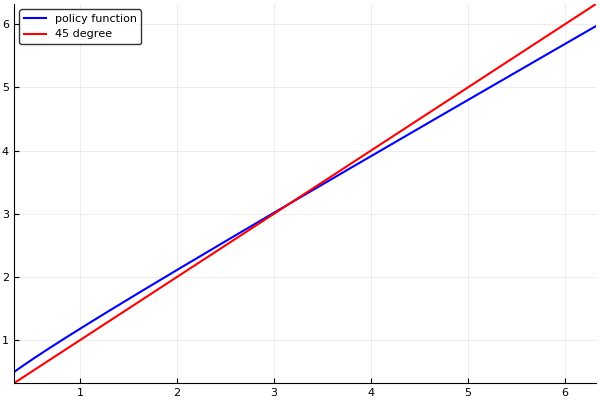

In [8]:
plot(agrid,pol_a, label="policy function",color="blue",linewidth=1.5)
plot!(agrid,agrid, label="45 degree",color="red",linewidth=1.5)


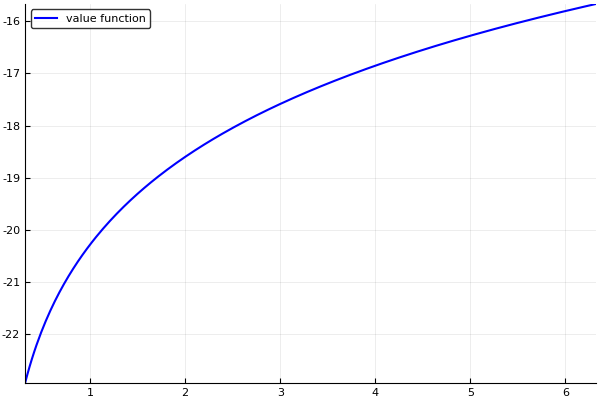

In [9]:
plot(agrid,v0,label="value function",color="blue",linewidth=1.5)